# Critical Topic Modeling

The episodes are about four to four and a half hours long. That is a lot of time to spend watching something, so I wanted to know how well an LDA model can describe what happened and if it can tell me the order of which the topics happen. I am coming for you Flando Maltrizian!

## Import Libraries

In [1]:
!pip install pyLDAvis==3.3.1

     |████████████████████████████████| 1.7 MB 9.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=4f90c41271644a580478b5a75a510e59319e8b119f09b4ac48307beda3908a51
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [30]:
!pip install ipywidgets

In [2]:
!pip install pandarallel==1.4.8

  Created wheel for pandarallel: filename=pandarallel-1.4.8-py3-none-any.whl size=16111 sha256=80df34e8c393d302fcd88d2de814f44fe778760ccc96b8ba99ac58c1eeb81dea
  Stored in directory: /root/.cache/pip/wheels/c7/f2/4e/e40c8b9344cccf6b8a02d8d8808ba837e72b607c4be946878a
Successfully built pandarallel


In [3]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.3 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=97f48adc4c976117d9ebfec4c783a0e4005ebc10347fb99b14d5697f34b0f3d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-5sp01on3/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [1]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim_models 

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pandarallel import pandarallel

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Loading in data, cleaning, tokenizing


### Load

In [1]:
text = open('/content/CR3-16.txt', 'r',encoding = "ISO-8859-1").read()

### Clean

I am probably going to have two cleaning functions. One is going to clean the entire episode. The second will as best as possible only pull lines of the characters and Matt.

First: Clean the entire episode and create a dataframe of lines

In [2]:
def cr_episode_cleaner(episode):
    """
    Clean the data of the entire episode and create a dataframe of the spoken
    lines in the episode. 

    This includes intro, break, outro, character dialog, etc.
    
    Parameters
    ----------
    episode: A large string containing everything spoken during the episode

    Returns
    -------
    lines: A dataframe where every entry is a line spoken during the episode
    """

    return lines

Second: Clean the data of the parts of the episode where there is only character and DM's dialog.

In [33]:
def cr_dialog_cleaner(episode):
    """
    Clean the data of the entire episode and create a dataframe of the spoken
    lines in the episode. 

    This includes intro, break, outro, character dialog, etc.
    
    Parameters
    ----------
    episode: A large string containing everything spoken during the episode

    Returns
    -------
    lines: A dataframe where every entry is dialog spoken during the episode
    """

    # How to locate where the dialog starts and stops
    ending_intro = "And welcome back."
    starting_break = "And we'll pick up from there after our break."
    starting_outro = "We'll pick up on that next week."
    parts = episode.split(ending_intro)
    first_part = parts[1].split(starting_break)[0]
    second_part = parts[-1].split(starting_outro)[0]
    print(first_part[:200])
    print(second_part[:200])
    full_dialog= first_part + "/n" + second_part

    # regex
    remove = string.punctuation
    remove = remove.replace("#", "") # don't remove hyphens
    removing_punctuation = r"[{}]".format(remove)
    non_alpha = '[^a-zA-Z#]'
    spaces = '[^\S ]+'
    multi_white_spaces = "[ ]{2,}"

    full_dialog = re.sub(removing_punctuation, "", full_dialog)
    full_dialog = re.sub(non_alpha, " ", full_dialog)
    full_dialog = re.sub(spaces, '', full_dialog)
    full_dialog = re.sub(multi_white_spaces, " ", full_dialog)
    return pd.DataFrame(full_dialog.lower().split(" # "),columns=['lines'])

In [34]:
full_dialog_df = cr_dialog_cleaner(text)

  
So, last we left off, Hells Bells.  
Bells Hells, I should say.  
# SAM
Yes, you should.  
# MATT
The other way around.  
Brain, thank you.  
# LIAM
First was exclamation, then you said their name.
  
So.  
As Bells Hells are currently jaunting into the darkness, retracing their steps through the aspects of this abandoned mine that they had originally come through, the arcane dome orb that curre


In [35]:
full_dialog_df.head()

,lines
0,so last we left off hells bells bells hells i...
1,sam yes you should
2,matt the other way around brain thank you
3,liam first was exclamation then you said their...
4,matt indeed i was just excited and then presen...


### Tokenizing data for LDA

In [36]:
# identify how many processors your machine has - save the result to `n_processors`
import multiprocessing

n_processors = multiprocessing.cpu_count()
# subtract 1 from n_processors - save the result to `nb_workers`
nb_workers = n_processors - 1
# we must initalize pandarallel before we can use it
pandarallel.initialize(progress_bar=True, nb_workers=nb_workers)
# so that the progress bars will work
from pandarallel.utils import progress_bars
progress_bars.is_notebook_lab = lambda : True

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [37]:
nlp = spacy.load('en_core_web_md')

In [38]:
# create our tokens in the form of lemmas 
full_dialog_df['lemmas'] = full_dialog_df['lines'].parallel_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])

In [39]:
# Create lemma dictionary using Dictionary - save result to `id2word`
id2word = corpora.Dictionary(full_dialog_df['lemmas'])

# Create Term Document Frequency list - save result to `corpus`
# Term Document Frequency -- different format, but equivalent in function to the document-term matrix we used in sklearn
corpus = [id2word.doc2bow(doc_lemmas) for doc_lemmas in full_dialog_df['lemmas']]

## LDA Topic Modeling


### Gridsearch topic numbers

In [40]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [55]:
%%time 
start=2; limit=14;  step=2;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=full_dialog_df['lemmas'], start=start, limit=limit, step=step)

CPU times: user 26.6 s, sys: 3.99 s, total: 30.6 s
Wall time: 29.3 s


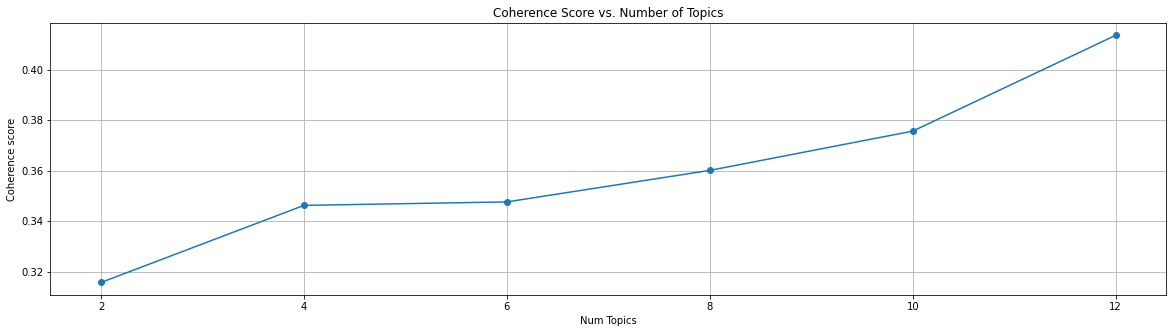

In [56]:
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

In [57]:
# use np.argmax() to get index of largest coherence value from coherence_values - save result to `max_cohereance_val_index`
max_coherence_val_index = np.argmax(coherence_values)
# use `max_coherence_val_index` to index model_list for the corresponding model - save result to `lda_trained_model`
lda_trained_model = model_list[max_coherence_val_index]

In [58]:
lda_trained_model.print_topics()

[(0,
  '0.085*"laughter" + 0.068*"matt" + 0.056*"point" + 0.045*"damage" + 0.034*"need" + 0.032*"sam" + 0.030*"take" + 0.029*"laudna" + 0.026*"throw" + 0.024*"day"'),
 (1,
  '0.101*"matt" + 0.063*"yes" + 0.042*"mean" + 0.033*"check" + 0.031*"gus" + 0.025*"hard" + 0.023*"right" + 0.023*"plus" + 0.022*"sorry" + 0.021*"fearne"'),
 (2,
  '0.254*"marisha" + 0.145*"oh" + 0.038*"travis" + 0.036*"laura" + 0.030*"shit" + 0.030*"not" + 0.029*"sleep" + 0.026*"fuck" + 0.026*"god" + 0.019*"fucking"'),
 (3,
  '0.227*"taliesin" + 0.088*"right" + 0.047*"little" + 0.036*"matt" + 0.023*"yep" + 0.019*"night" + 0.019*"leave" + 0.016*"bit" + 0.016*"drink" + 0.016*"away"'),
 (4,
  '0.171*"okay" + 0.169*"laura" + 0.158*"ashley" + 0.046*"matt" + 0.042*"want" + 0.030*"sam" + 0.028*"great" + 0.023*"not" + 0.018*"fine" + 0.013*"think"'),
 (5,
  '0.161*"go" + 0.136*"be" + 0.048*"laura" + 0.045*"try" + 0.018*"run" + 0.016*"use" + 0.015*"attack" + 0.012*"gold" + 0.011*"action" + 0.010*"chain"'),
 (6,
  '0.177*"matt

### Visualize topics

In [59]:
# plot your topics here -- using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_trained_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.130831  0.066458       1        1  12.432731
10    -0.045912  0.095416       2        1   8.999143
8      0.011471  0.046632       3        1   8.865964
5     -0.126328 -0.144464       4        1   8.723554
11    -0.215862  0.196469       5        1   8.511923
7      0.038793 -0.254381       6        1   8.471283
0      0.165201  0.025683       7        1   7.906136
4     -0.032501 -0.220715       8        1   7.788061
2     -0.285528  0.006256       9        1   7.487440
1      0.142755  0.061196      10        1   7.131091
3      0.089410  0.122631      11        1   7.030518
6      0.127670 -0.001181      12        1   6.652154, topic_info=         Term        Freq       Total Category  logprob  loglift
269   marisha  377.000000  377.000000  Default  30.0000  30.0000
431      yeah  348.000000  348.000000  Default  29.0000  29.0000
446  taliesin  317.000000  317.000000  Default  28.0000  28.0000
327         s  309.000000  309.000000  Default  27.0000  27.0000
406      okay  264.000000  264.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
559    strike   18.573129   28.604004  Topic12  -4.2617   2.2784
7        matt  232.751138  889.740152  Topic12  -1.7334   1.3693
9         way   28.409940   54.323635  Topic12  -3.8367   2.0620
107        go   30.871710  310.259602  Topic12  -3.7536   0.4027
215     shade    7.852043   63.947148  Topic12  -5.1226   0.6129

[500 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
505       6  0.807987  ability
835       6  0.942617     able
582       9  0.811013  academy
969       4  0.792264   action
969       8  0.176059   action
...     ...       ...      ...
1838      2  0.910193    wrong
987       8  0.917181      yay
431       6  0.998894     yeah
482      11  0.969760      yep
5        10  0.993943      yes

[508 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 11, 9, 6, 12, 8, 1, 5, 3, 2, 4, 7])

### Name Topics